In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from  sklearn.metrics import mean_absolute_percentage_error

In [33]:
def descomposicion(df_train, df_ori):
    decomposition = seasonal_decompose(df_train, model="additive",  period=52)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(10,7))
    plt.subplot(411)
    plt.plot(df_ori, label = "Original", color = "blue")
    plt.legend(loc = "best")
    plt.subplot(412)
    plt.plot(trend, label = "Tendencia", color = "blue")
    plt. legend(loc = "best")
    plt.subplot(413)
    plt.plot(seasonal, label = "Estacionaliedad", color = "blue")
    plt. legend(loc = "best")
    plt.subplot(414)
    plt.plot(residual, label = "Residuos", color = "blue")
    plt. legend(loc = "best")

In [105]:
def predicciones(n_periodos, modelo, df_train, df_ori, categoria, df_test):
    # Forecast
    #fitted = resultados_sari.get_forecast(n_periodos).predicted_mean
    fitted, confint = modelo.predict(n_periods=25, return_conf_int=True)
    index_of_fc = pd.date_range(df_train.index[-1], periods = n_periodos, freq='W-SUN')
    #confint = resultados_sari.get_forecast(25).conf_int()
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    # Plot
    plt.figure(figsize=(6,6), dpi=100)
    plt.plot(df_ori)
    plt.plot(fitted_series, color='darkgreen')
    plt.plot(lower_series, color='k')
    plt.plot(upper_series, color='k')
    #plt.fill_between(index_of_fc, confint["upper y"].values, confint["lower y"].values, color='k', alpha=.15)
    plt.fill_between(index_of_fc, confint[:, 1], confint[:, 0], color='k', alpha=.15)

    plt.title("SARIMA - Predicción para el número de "+categoria+" en CDMX")
    plt.show()
    
    mape= mean_absolute_percentage_error(df_test[0:n_periodos], fitted)

    print('MAPE: %f' %mape)

In [119]:
def model_plot(df_train, n_periodos, df_ori, categoria, df_test):
    
    model= pm.auto_arima(df_train, 
                      test='adf',
                      seasonal=True,
                      m=52,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

    print(model.summary())
    
    model.plot_diagnostics(figsize = (9,7))
    predicciones(n_periodos, model, df_train, df_ori, categoria, df_test)

## LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO

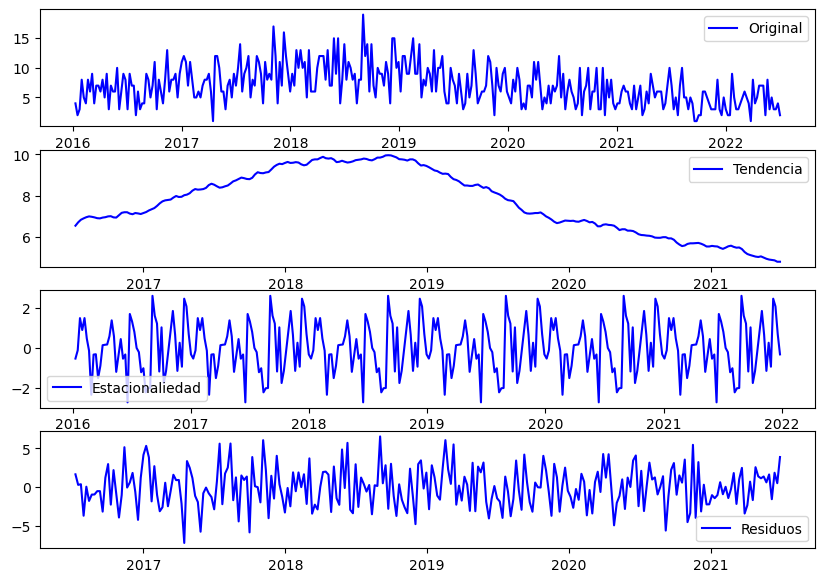

In [141]:
lesiones_arma = pd.read_csv("../Data/lesiones_arma.csv", parse_dates=["fecha_hechos"])
lesiones_arma.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
lesiones_arma.index = pd.DatetimeIndex(lesiones_arma.fecha_hechos)

lesiones_arma_x_sem = lesiones_arma.resample("W", on = "fecha_hechos").size()
ts_train_lesiones_arma=lesiones_arma_x_sem[lesiones_arma_x_sem.index<'2022']
ts_test_lesiones_arma=lesiones_arma_x_sem[lesiones_arma_x_sem.index>='2022']

descomposicion(ts_train_lesiones_arma, lesiones_arma_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1628.217, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1608.064, Time=0.94 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1614.961, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2183.313, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1606.065, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1608.064, Time=0.71 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=1610.060, Time=1.23 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1595.330, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1597.296, Time=1.42 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=1597.297, Time=0.74 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=1599.296, Time=1.57 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=1593.277, Time=0.07 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=1595.246, Time=1.53 sec
 ARIMA(3,0,0)(0,0,1)[52]

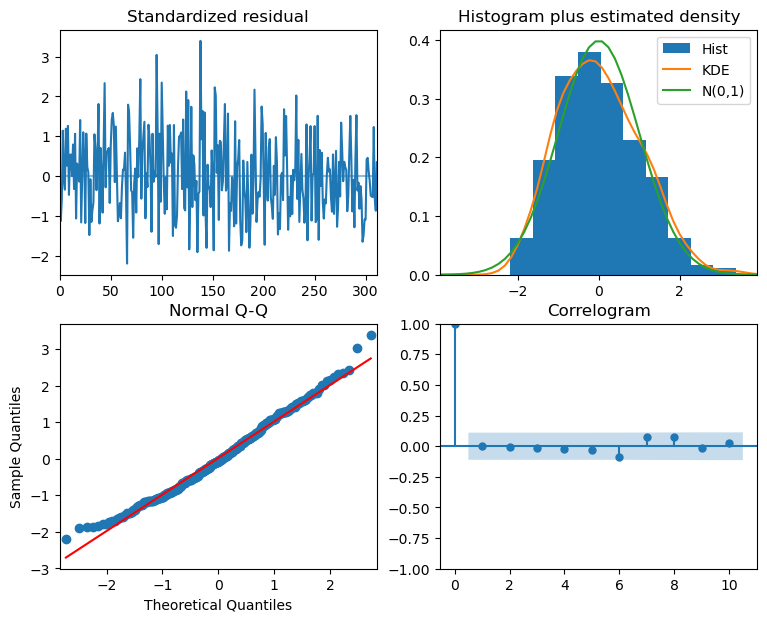

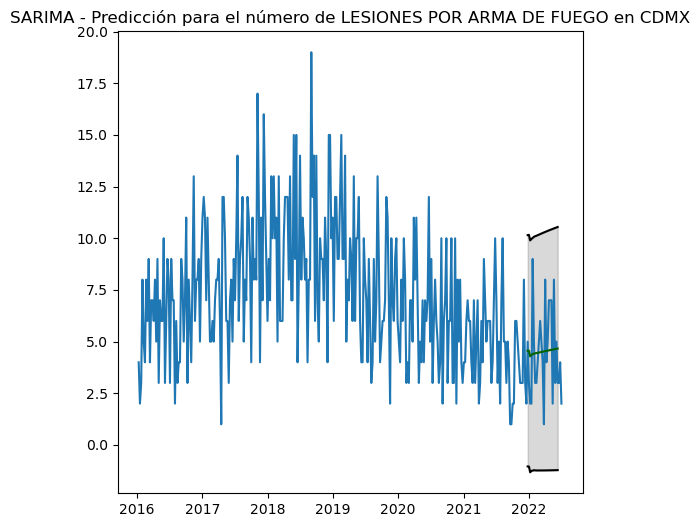

MAPE: 0.555618


In [142]:
model_plot(df_train = ts_train_lesiones_arma, n_periodos = 25, df_ori = lesiones_arma_x_sem, 
           categoria = "LESIONES POR ARMA DE FUEGO", df_test = ts_test_lesiones_arma)

## VIOLACION

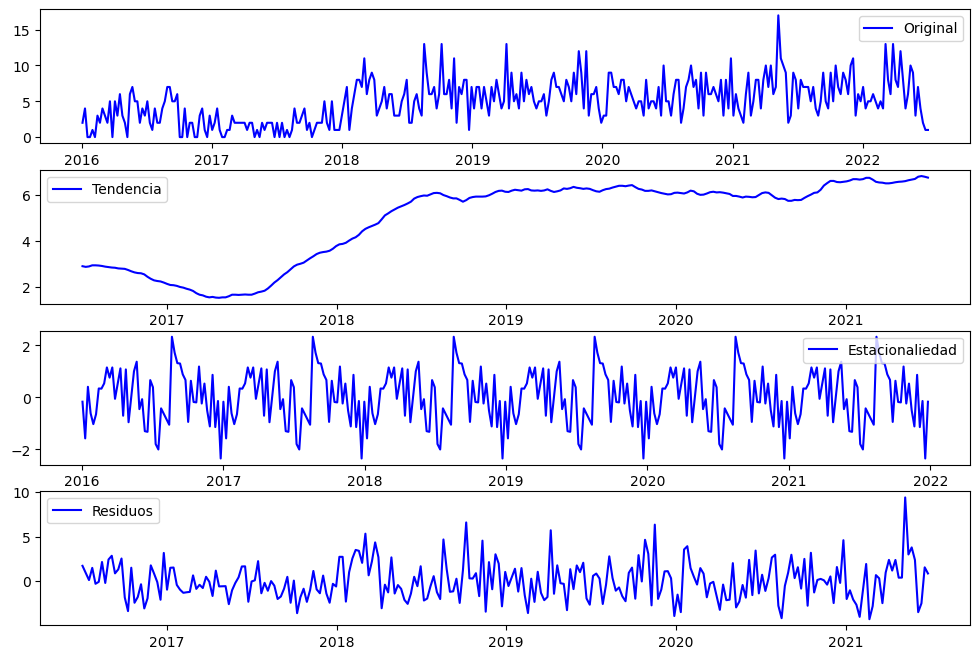

In [22]:
violaciones = pd.read_csv("../Data/violaciones.csv", parse_dates=["fecha_hechos"])
violaciones.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
violaciones.index = pd.DatetimeIndex(violaciones.fecha_hechos)

violaciones_x_sem = violaciones.resample("W", on = "fecha_hechos").size()
ts_train_violaciones=violaciones_x_sem[violaciones_x_sem.index<'2022']
ts_test_violaciones=violaciones_x_sem[violaciones_x_sem.index>='2022']

descomposicion(ts_train_violaciones, violaciones_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.98 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1576.467, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1512.050, Time=0.91 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1539.185, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1984.784, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1510.099, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=1512.050, Time=0.54 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1473.515, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1474.993, Time=1.12 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=1474.981, Time=0.82 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=1461.424, Time=0.08 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=1462.576, Time=1.34 sec
 ARIMA(3,0,0)(0,0,1)[52] intercept

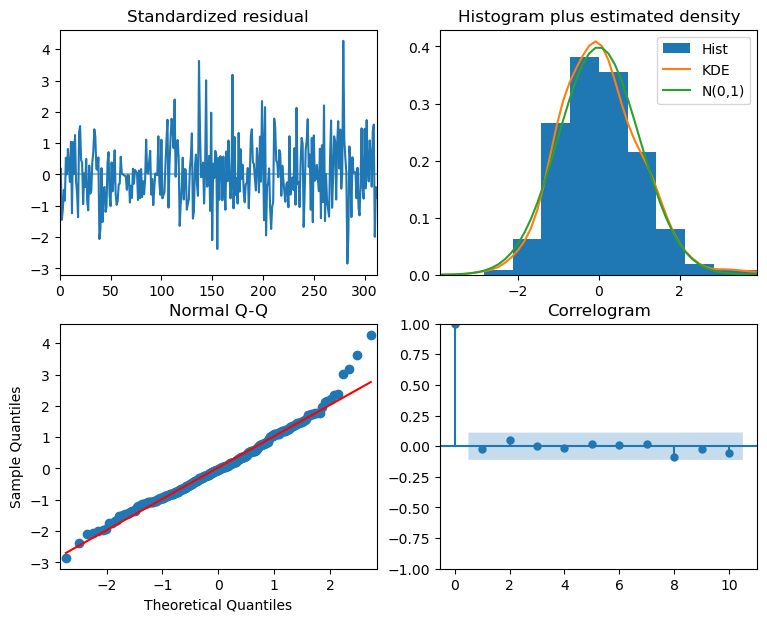

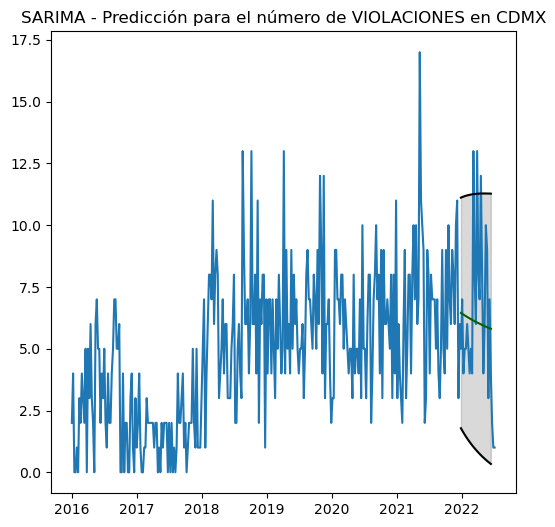

MAPE: 0.403033


In [143]:
model_plot(df_train = ts_train_violaciones, n_periodos = 25, df_ori = violaciones_x_sem, 
           categoria = "VIOLACIONES", df_test = ts_test_violaciones)

## HOMICIDIO DOLOSO

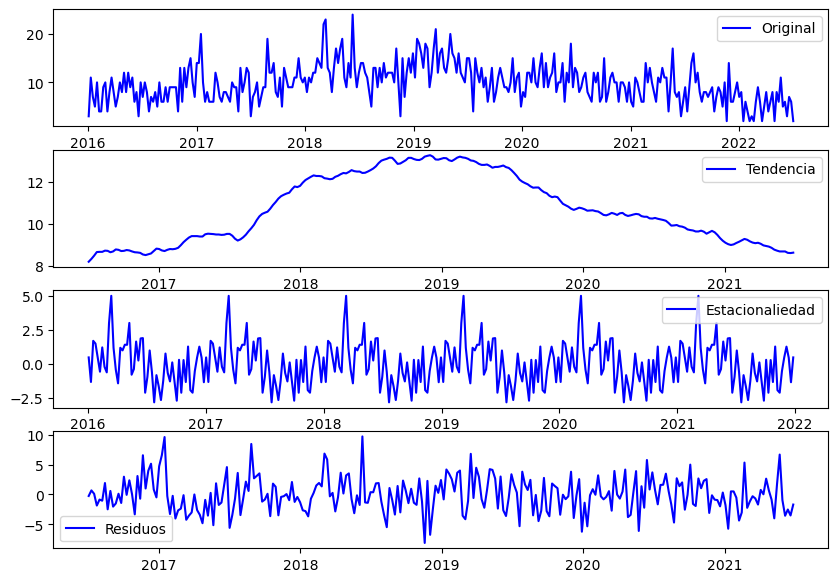

In [44]:
homicidio = pd.read_csv("../Data/homicidios.csv", parse_dates=["fecha_hechos"])
homicidio.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
homicidio.index = pd.DatetimeIndex(homicidio.fecha_hechos)

homicidio_x_sem = homicidio.resample("W", on = "fecha_hechos").size()
ts_train_homicidio=homicidio_x_sem[homicidio_x_sem.index<'2022']
ts_test_homicidio=homicidio_x_sem[homicidio_x_sem.index>='2022']

descomposicion(ts_train_homicidio, homicidio_x_sem)

In [45]:
model_homicidio = pm.auto_arima(ts_train_homicidio, 
                      test='adf',
                      seasonal=True,
                      m=52,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1722.767, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1685.979, Time=1.03 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1693.882, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2388.490, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1688.370, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=1683.862, Time=6.56 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=14.52 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=1686.586, Time=1.56 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=1712.494, Time=7.15 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=1676.416, Time=8.25 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1676.944, Time=1.30 sec
 ARIMA(2,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=14.38 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=1678.012, Time=1.82 sec
 ARIMA(3,0,0)(2,0,0)[52] interce

In [46]:
model_homicidio_sari=SARIMAX(ts_train_homicidio, order=(1,0,1), seasonal_order=(0, 0, 0, 52))
result_sari=model_homicidio_sari.fit()
result_sari.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  313
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -823.195
Date:                Wed, 26 Oct 2022   AIC                           1652.389
Time:                        15:33:05   BIC                           1663.628
Sample:                    01-03-2016   HQIC                          1656.881
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9986      0.002    486.163      0.000       0.995       1.003
ma.L1         -0.8639      0.028    -31.004      0.000      -0.918      -0.809
sigma2        11.1529      0.830     13.432      0.000       9.525      12.780
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 9.11
Prob(Q):                              0.55   Prob(JB):                         0.01
Heteroskedasticity (H):               0.96   Skew:                             0.34
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

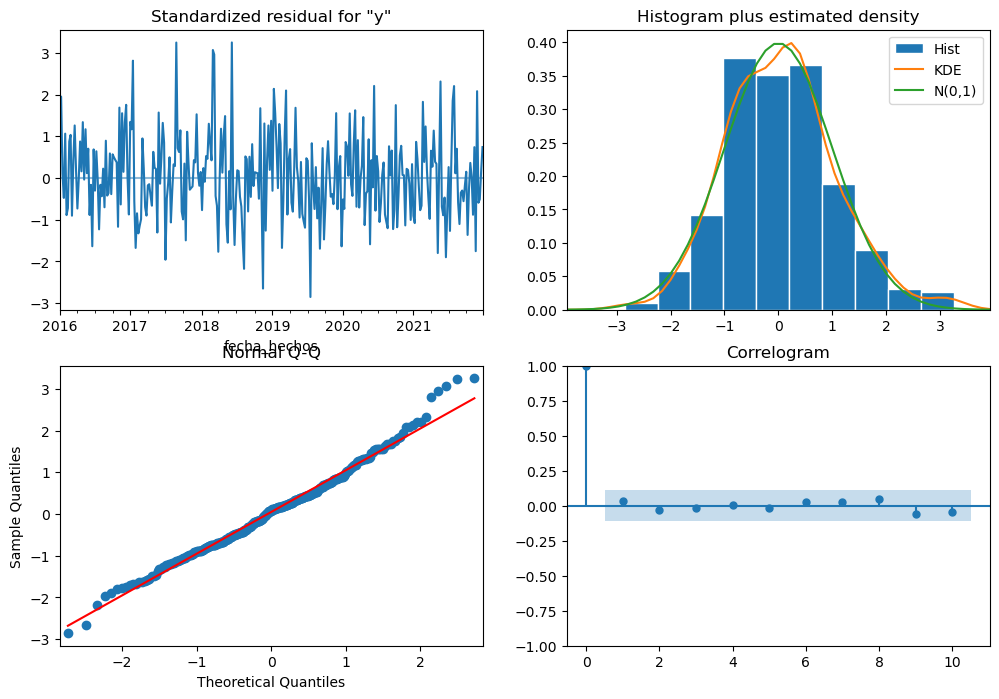

In [47]:
result_sari.plot_diagnostics(figsize=(12,8))
plt.show()

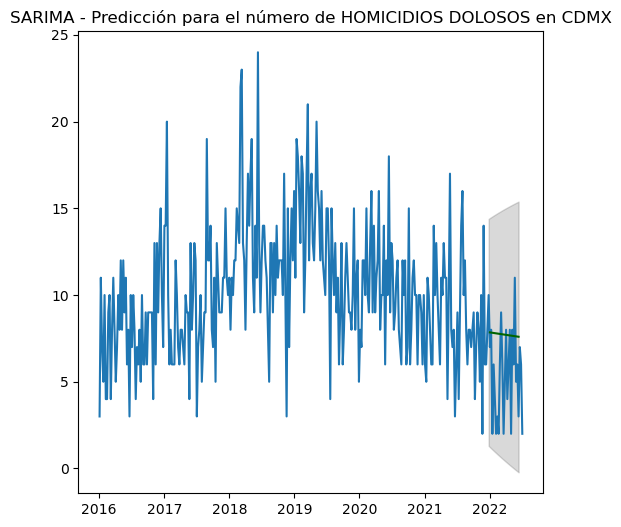

In [48]:
predicciones(n_peridos = 25, resultados_sari = result_sari, df_train = ts_train_homicidio, df_ori = homicidio_x_sem, 
             categoria = "HOMICIDIOS DOLOSOS")

## ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA

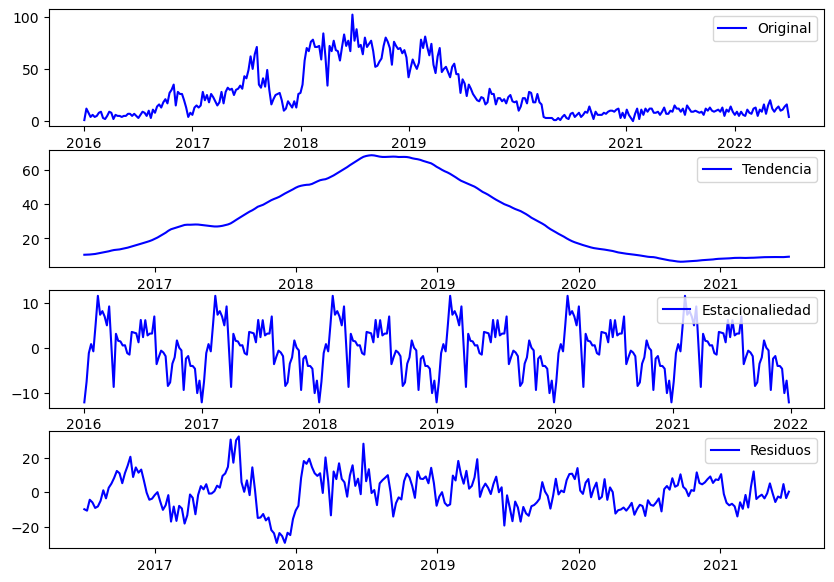

In [49]:
robo_metro = pd.read_csv("../Data/robo_metro.csv", parse_dates=["fecha_hechos"])
robo_metro.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_metro.index = pd.DatetimeIndex(robo_metro.fecha_hechos)

robo_metro_x_sem = robo_metro.resample("W", on = "fecha_hechos").size()
ts_train_robo_metro=robo_metro_x_sem[robo_metro_x_sem.index<'2022']
ts_test_robo_metro=robo_metro_x_sem[robo_metro_x_sem.index>='2022']

descomposicion(ts_train_robo_metro, robo_metro_x_sem)

In [50]:
model_robo_metro = pm.auto_arima(ts_train_robo_metro, 
                      test='adf',
                      seasonal=True,
                      m=52,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2175.680, Time=3.88 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2215.259, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2177.800, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2168.480, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2213.262, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2170.288, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2170.400, Time=0.99 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2170.344, Time=2.74 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2168.401, Time=0.44 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2170.400, Time=3.12 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=2172.401, Time=4.23 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2213.849, Time=0.37 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2170.377, Time=0.74 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2170.372, Time=0.88 sec
 ARIMA(1,1,2)(1,0,0

In [51]:
model_robo_metro_sari=SARIMAX(ts_train_robo_metro, order=(0,1,1), seasonal_order=(1, 0, 0, 52))
result_sari=model_robo_metro_sari.fit()
result_sari.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  313
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1080.203
Date:                             Wed, 26 Oct 2022   AIC                           2166.407
Time:                                     15:39:18   BIC                           2177.636
Sample:                                 01-03-2016   HQIC                          2170.894
                                      - 12-26-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4095      0.034    -12.009      0.000      -0.476      -0.343
ar.S.L52       0.1078      0.046      2.327      0.020       0.017       0.199
sigma2        59.3806      2.959     20.067      0.000      53.581      65.180
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               134.67
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

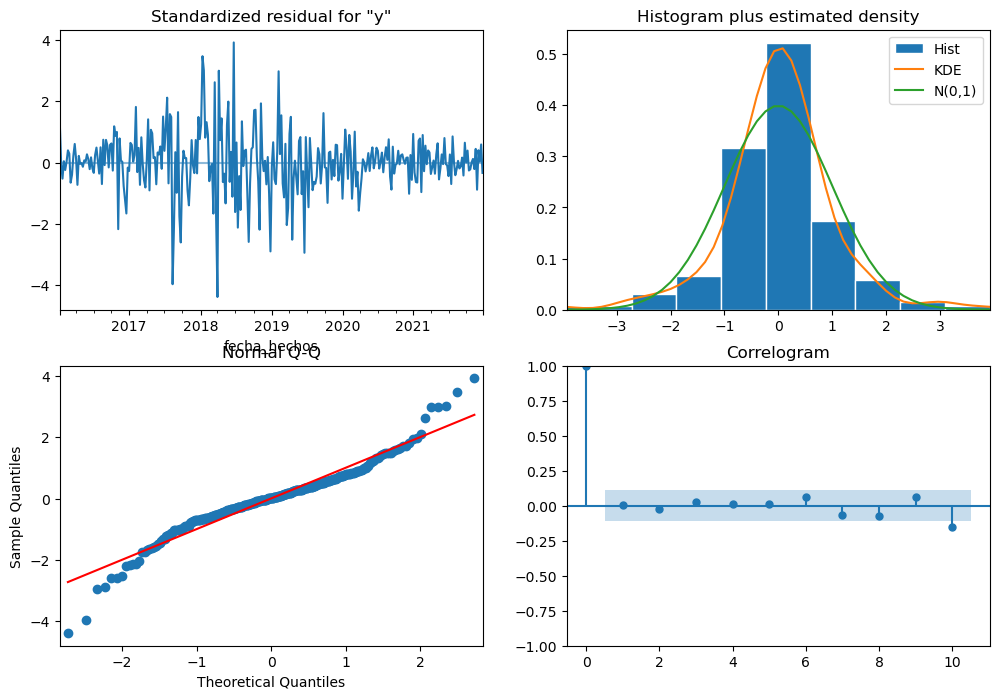

In [52]:
result_sari.plot_diagnostics(figsize=(12,8))
plt.show()

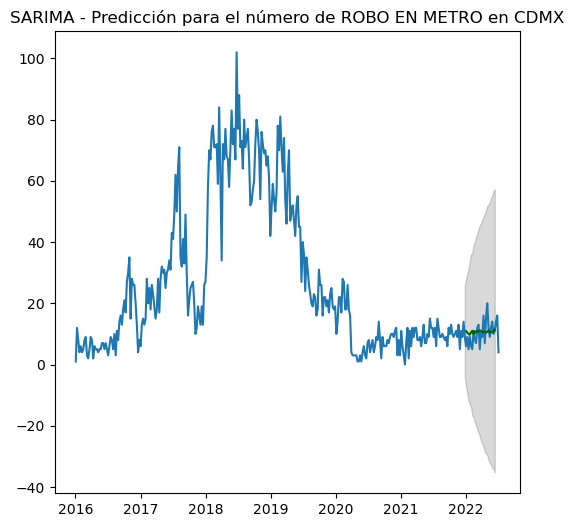

MAPE: 0.366325


In [81]:
predicciones(n_periodos = 25, resultados_sari = result_sari, df_train = ts_train_robo_metro, df_ori = robo_metro_x_sem, 
             categoria = "ROBO EN METRO", df_test = ts_test_robo_metro)

## ROBO A REPARTIDOR CON Y SIN VIOLENCIA

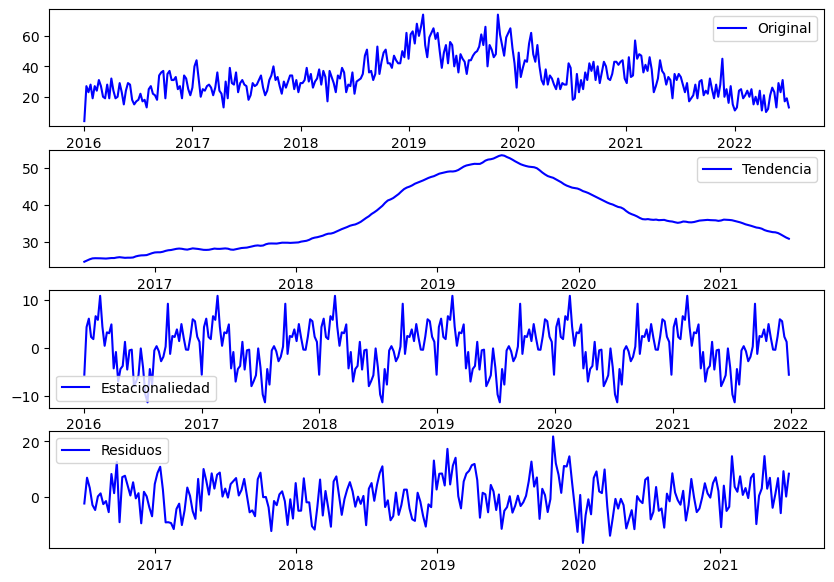

In [112]:
robo_repartidores = pd.read_csv("../Data/robo_repartidores.csv", parse_dates=["fecha_hechos"])
robo_repartidores.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_repartidores.index = pd.DatetimeIndex(robo_repartidores.fecha_hechos)

robo_repartidores_x_sem = robo_repartidores.resample("W", on = "fecha_hechos").size()
ts_train_robo_repartidores=robo_repartidores_x_sem[robo_repartidores_x_sem.index<'2022']
ts_test_robo_repartidores=robo_repartidores_x_sem[robo_repartidores_x_sem.index>='2022']

descomposicion(ts_train_robo_repartidores, robo_repartidores_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=2153.677, Time=5.41 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2253.780, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2196.249, Time=0.88 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2150.052, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2251.785, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2155.163, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2151.516, Time=1.41 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2151.651, Time=3.45 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2149.663, Time=0.69 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2151.563, Time=3.82 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=16.60 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2249.396, Time=0.53 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2148.211, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2153.895, Time=0.08 sec
 ARIMA(1,1,1)(2,0,0)[52

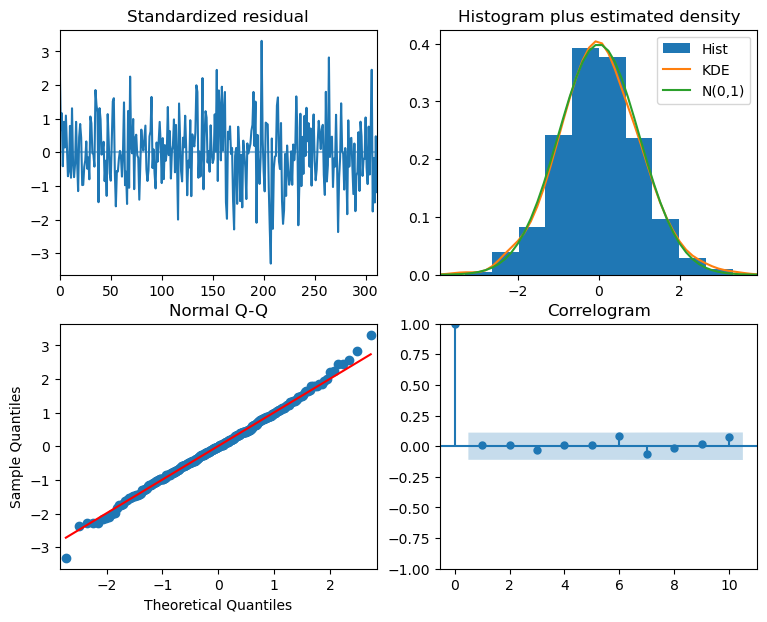

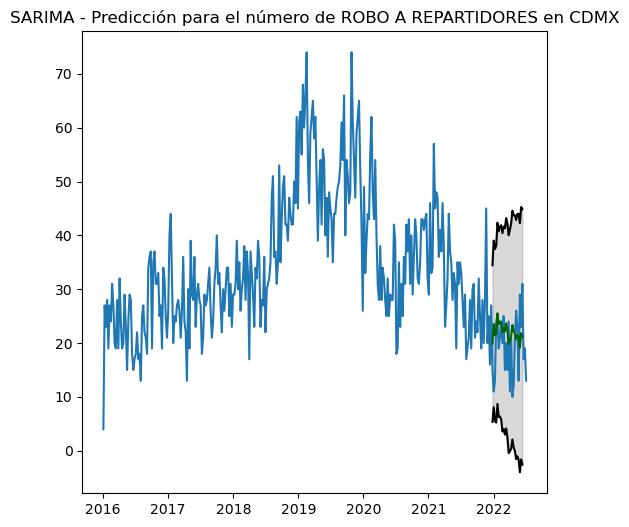

MAPE: 0.350641


In [113]:
model_plot(df_train = ts_train_robo_repartidores, n_periodos = 25, df_ori = robo_repartidores_x_sem, 
           categoria = "ROBO A REPARTIDORES", df_test = ts_test_robo_repartidores)

## ROBO A NEGOCIO CON VIOLENCIA

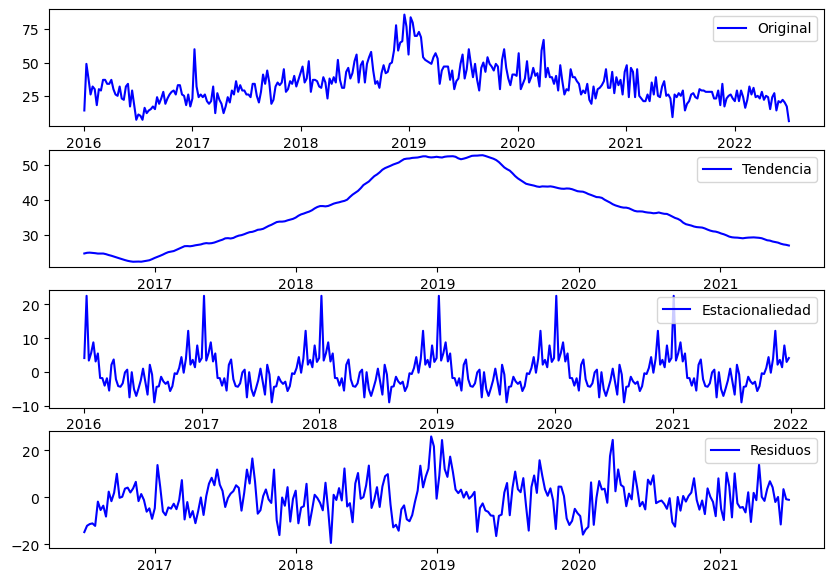

In [115]:
robo_neg_con = pd.read_csv("../Data/robo_neg_con.csv", parse_dates=["fecha_hechos"])
robo_neg_con.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_neg_con.index = pd.DatetimeIndex(robo_neg_con.fecha_hechos)

robo_neg_con_x_sem = robo_neg_con.resample("W", on = "fecha_hechos").size()
ts_train_robo_neg_con=robo_neg_con_x_sem[robo_neg_con_x_sem.index<'2022']
ts_test_robo_neg_con=robo_neg_con_x_sem[robo_neg_con_x_sem.index>='2022']

descomposicion(ts_train_robo_neg_con, robo_neg_con_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.88 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2322.233, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2268.919, Time=1.03 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2216.182, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2320.235, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2217.876, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2218.180, Time=3.21 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2216.126, Time=0.69 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2218.066, Time=3.59 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=10.75 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2319.164, Time=0.59 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2217.393, Time=0.98 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2217.079, Time=0.99 sec
 ARIMA(1,1,2)(1,0,0)[52] intercep

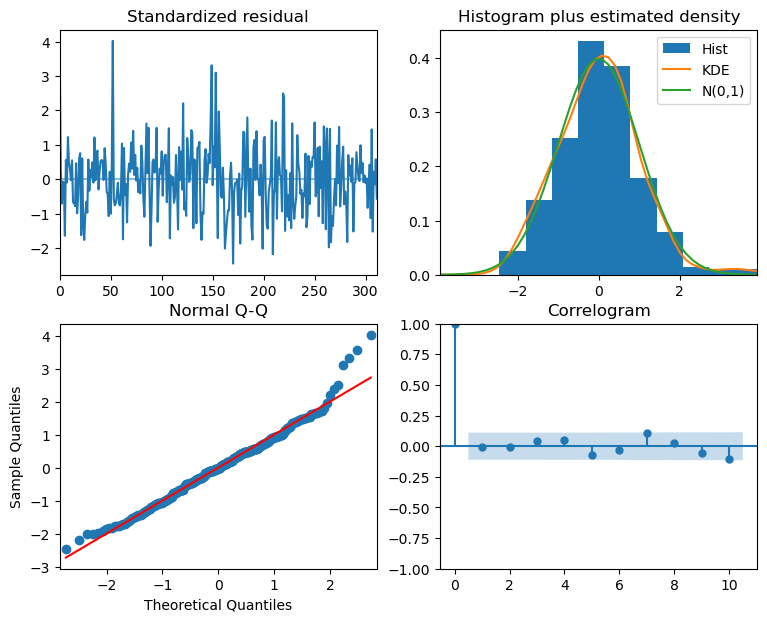

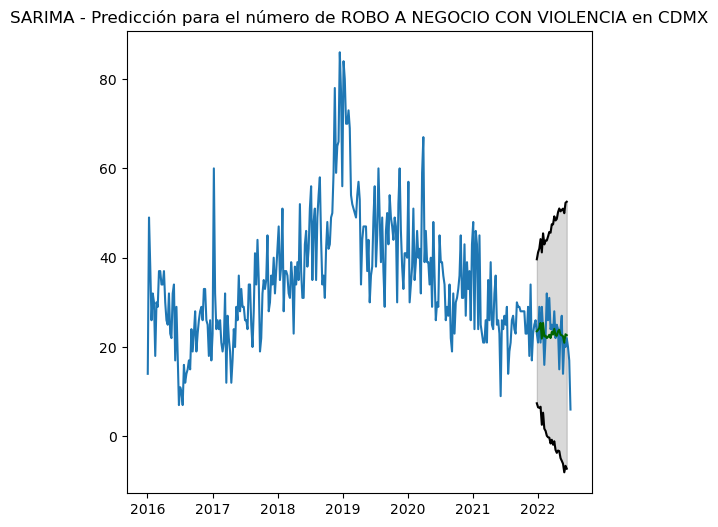

MAPE: 0.170160


In [116]:
model_plot(df_train = ts_train_robo_neg_con, n_periodos = 25, df_ori = robo_neg_con_x_sem, 
           categoria = "ROBO A NEGOCIO CON VIOLENCIA", df_test = ts_test_robo_neg_con)

## DELITOS SEXUALES

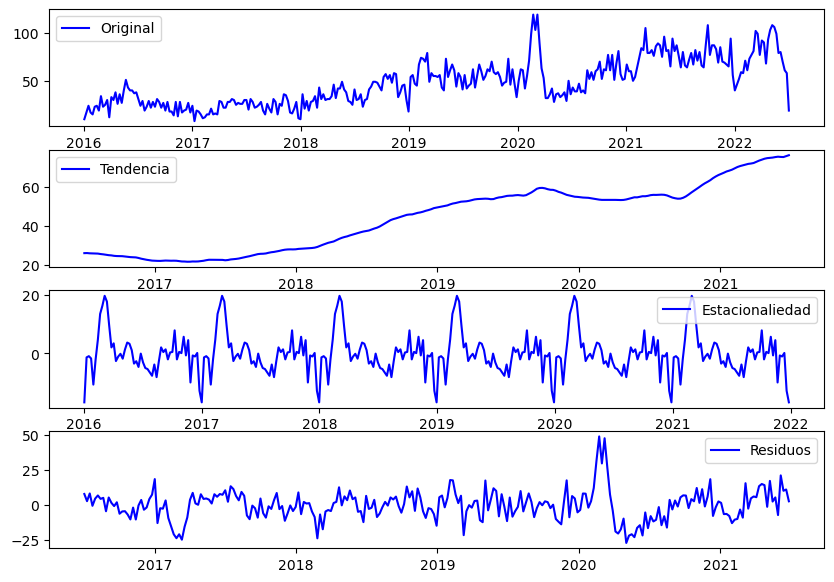

In [117]:
sexuales = pd.read_csv("../Data/sexuales.csv", parse_dates=["fecha_hechos"])
sexuales.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
sexuales.index = pd.DatetimeIndex(sexuales.fecha_hechos)

sexuales_x_sem = sexuales.resample("W", on = "fecha_hechos").size()
ts_train_sexuales=sexuales_x_sem[sexuales_x_sem.index<'2022']
ts_test_sexuales=sexuales_x_sem[sexuales_x_sem.index>='2022']

descomposicion(ts_train_sexuales, sexuales_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2353.638, Time=4.85 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2844.461, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2390.713, Time=1.20 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2592.763, Time=1.59 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3350.065, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2351.640, Time=3.52 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2367.526, Time=0.20 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=2353.639, Time=14.70 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2352.430, Time=4.00 sec
 ARIMA(2,0,2)(1,0,2)[52] intercept   : AIC=2355.637, Time=18.02 sec
 ARIMA(1,0,2)(0,0,1)[52] intercept   : AIC=2349.702, Time=1.99 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=2366.400, Time=0.14 sec
 ARIMA(1,0,2)(1,0,1)[52] intercept   : AIC=2351.700, Time=2.85 sec
 ARIMA(1,0,2)(0,0,2)[52] intercept   : AIC=2351.700, Time=8.65 sec
 ARIMA(1,0,2)(1,0

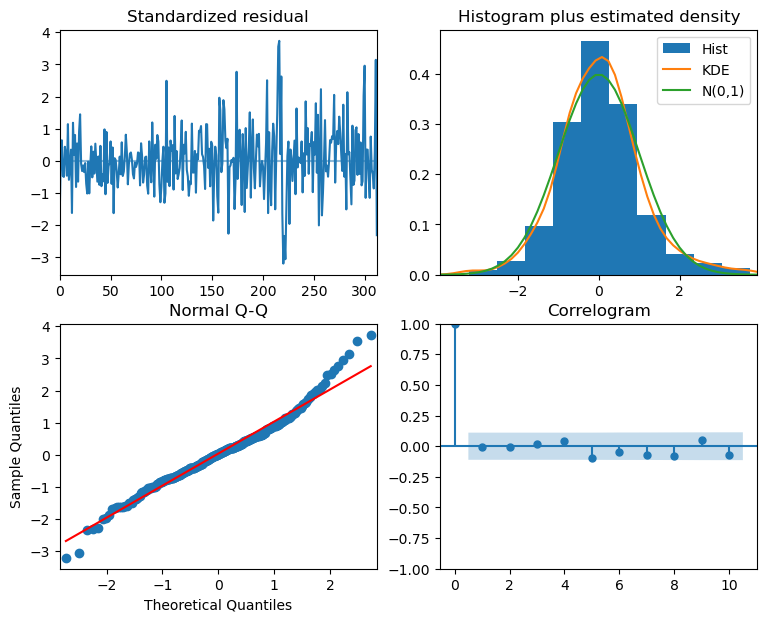

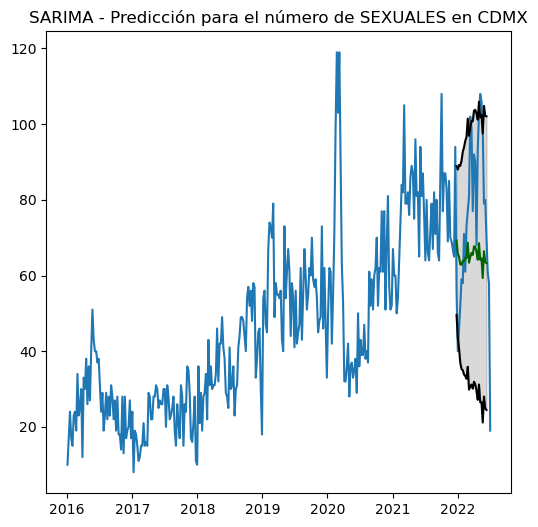

MAPE: 0.234707


In [118]:
model_plot(df_train = ts_train_sexuales, n_periodos = 25, df_ori = sexuales_x_sem, 
           categoria = "SEXUALES", df_test = ts_test_sexuales)

## ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA

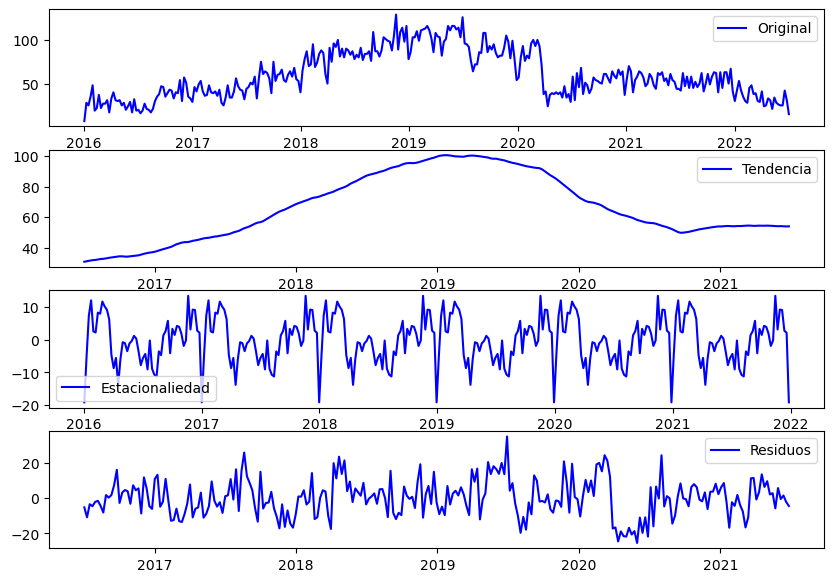

In [120]:
robo_pasajeros = pd.read_csv("../Data/robo_pasajeros.csv", parse_dates=["fecha_hechos"])
robo_pasajeros.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_pasajeros.index = pd.DatetimeIndex(robo_pasajeros.fecha_hechos)

robo_pasajeros_x_sem = robo_pasajeros.resample("W", on = "fecha_hechos").size()
ts_train_robo_pasajeros=robo_pasajeros_x_sem[robo_pasajeros_x_sem.index<'2022']
ts_test_robo_pasajeros=robo_pasajeros_x_sem[robo_pasajeros_x_sem.index>='2022']

descomposicion(ts_train_robo_pasajeros, robo_pasajeros_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=6.67 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2487.870, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2427.554, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2409.626, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2485.892, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2408.540, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2409.376, Time=0.77 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2409.057, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2409.717, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2427.141, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=2411.437, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=2406.687, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=2407.517, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[52]     

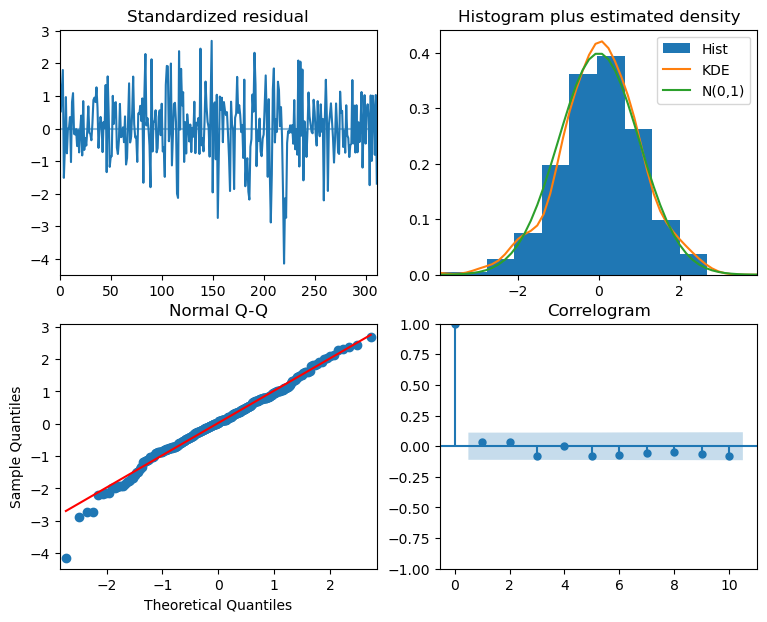

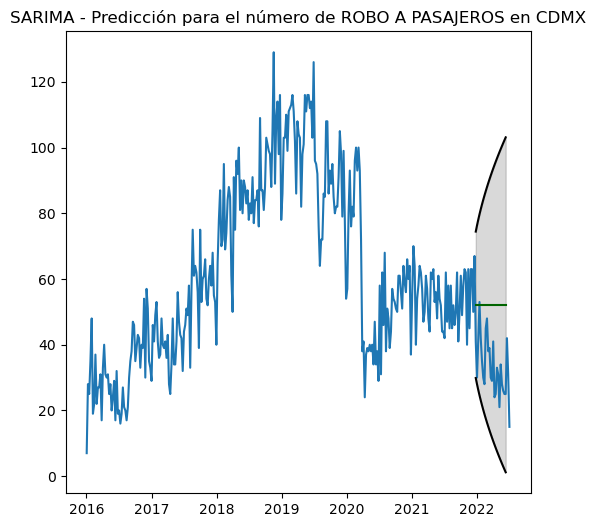

MAPE: 0.636433


In [121]:
model_plot(df_train = ts_train_robo_pasajeros, n_periodos = 25, df_ori = robo_pasajeros_x_sem, 
           categoria = "ROBO A PASAJEROS", df_test = ts_test_robo_pasajeros)

## ROBO A CASA SIN VIOLENCIA

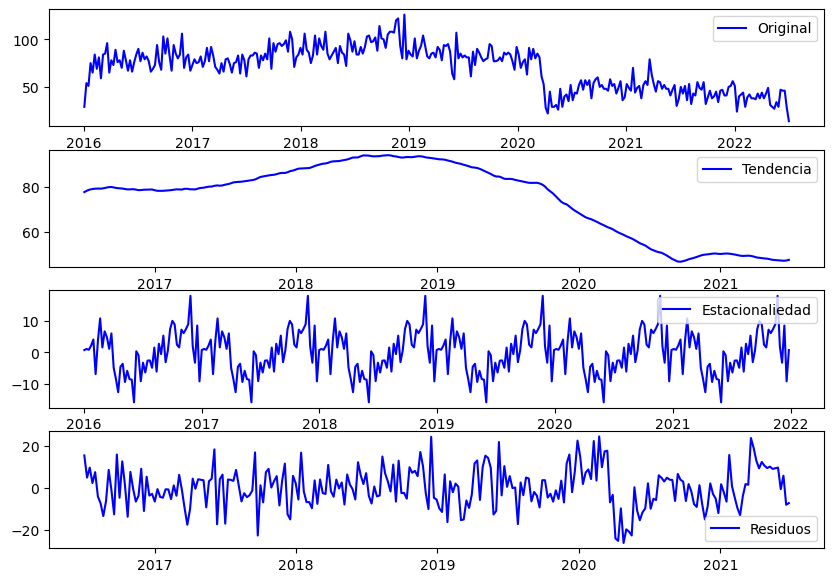

In [122]:
robo_casa_sin = pd.read_csv("../Data/robo_casa_sin.csv", parse_dates=["fecha_hechos"])
robo_casa_sin.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_casa_sin.index = pd.DatetimeIndex(robo_casa_sin.fecha_hechos)

robo_casa_sin_x_sem = robo_casa_sin.resample("W", on = "fecha_hechos").size()
ts_train_robo_casa_sin=robo_casa_sin_x_sem[robo_casa_sin_x_sem.index<'2022']
ts_test_robo_casa_sin=robo_casa_sin_x_sem[robo_casa_sin_x_sem.index>='2022']

descomposicion(ts_train_robo_casa_sin, robo_casa_sin_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=6.23 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2507.964, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2419.417, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2383.291, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2505.977, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2381.467, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2383.265, Time=0.64 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2382.386, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2382.462, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2417.485, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=2384.338, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=2379.469, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=2381.266, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[52]     

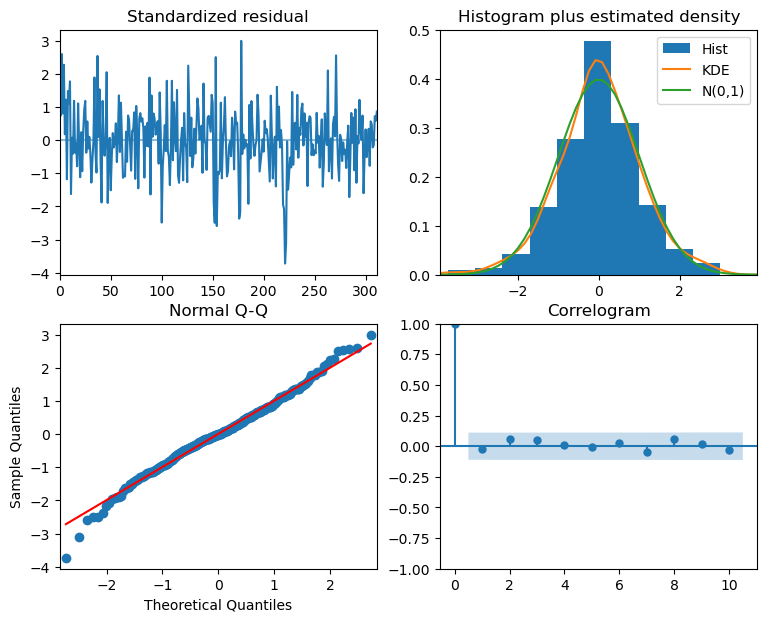

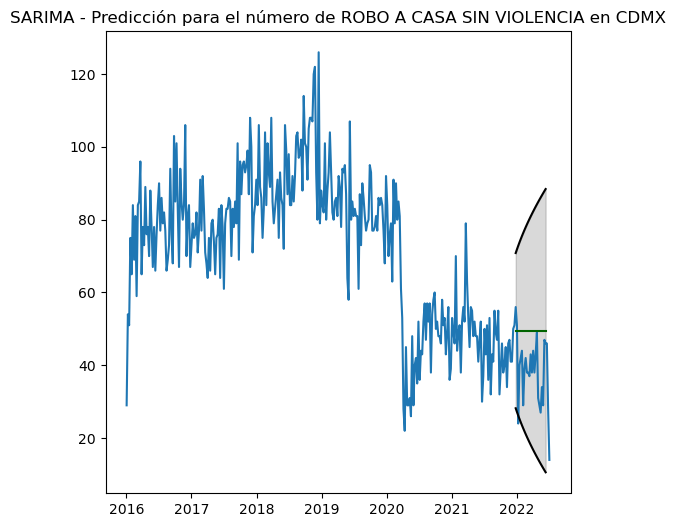

MAPE: 0.331514


In [123]:
model_plot(df_train = ts_train_robo_casa_sin, n_periodos = 25, df_ori = robo_casa_sin_x_sem, 
           categoria = "ROBO A CASA SIN VIOLENCIA", df_test = ts_test_robo_casa_sin)

## ROBO DE VEHICULO CON Y SIN VIOLENCIA

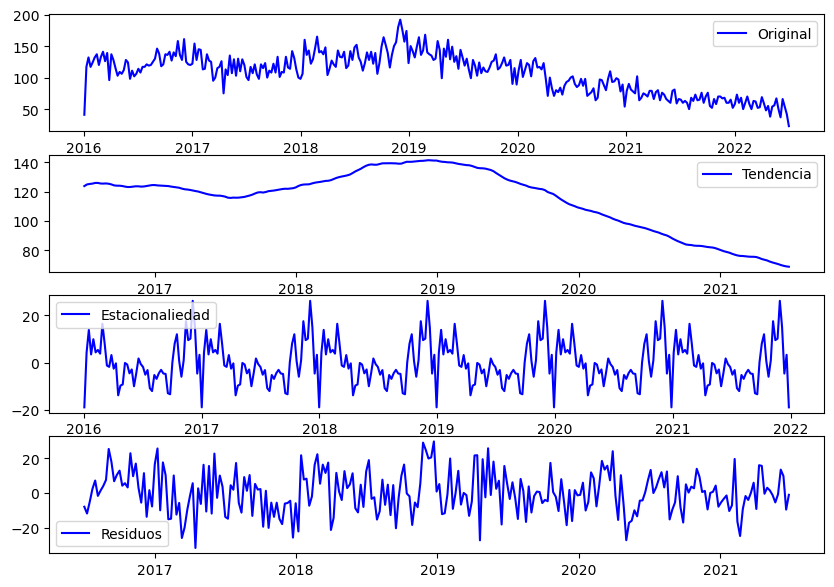

In [126]:
robo_carros = pd.read_csv("../Data/robo_carros.csv", parse_dates=["fecha_hechos"])
robo_carros.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_carros.index = pd.DatetimeIndex(robo_carros.fecha_hechos)

robo_carros_x_sem = robo_carros.resample("W", on = "fecha_hechos").size()
ts_train_robo_carros=robo_carros_x_sem[robo_carros_x_sem.index<'2022']
ts_test_robo_carros=robo_carros_x_sem[robo_carros_x_sem.index>='2022']

descomposicion(ts_train_robo_carros, robo_carros_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2680.961, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2616.200, Time=1.06 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2576.724, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2678.962, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2580.687, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2576.810, Time=5.43 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2575.767, Time=0.86 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2575.381, Time=4.84 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=16.49 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=2680.060, Time=3.71 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=2576.586, Time=4.83 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AIC=2576.721, Time=5.69 sec
 ARIMA(1,1,0)(2,0,0)[52] intercep

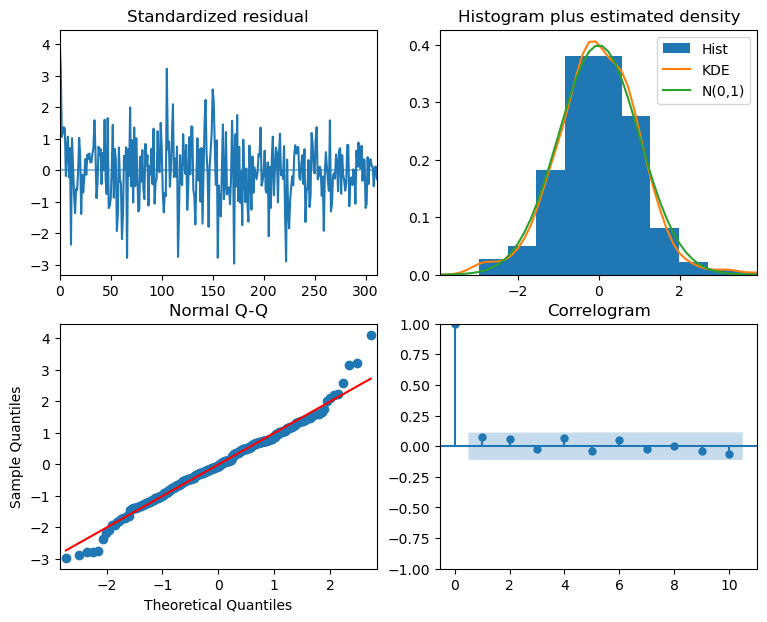

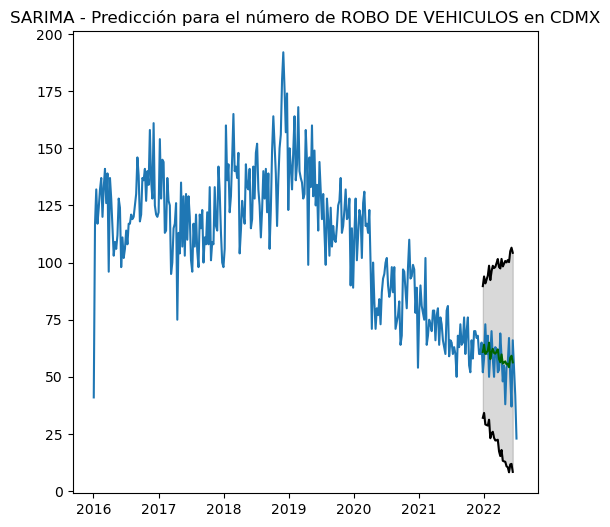

MAPE: 0.138239


In [127]:
model_plot(df_train = ts_train_robo_carros, n_periodos = 25, df_ori = robo_carros_x_sem, 
           categoria = "ROBO DE VEHICULOS", df_test = ts_test_robo_carros)

## AMENAZAS

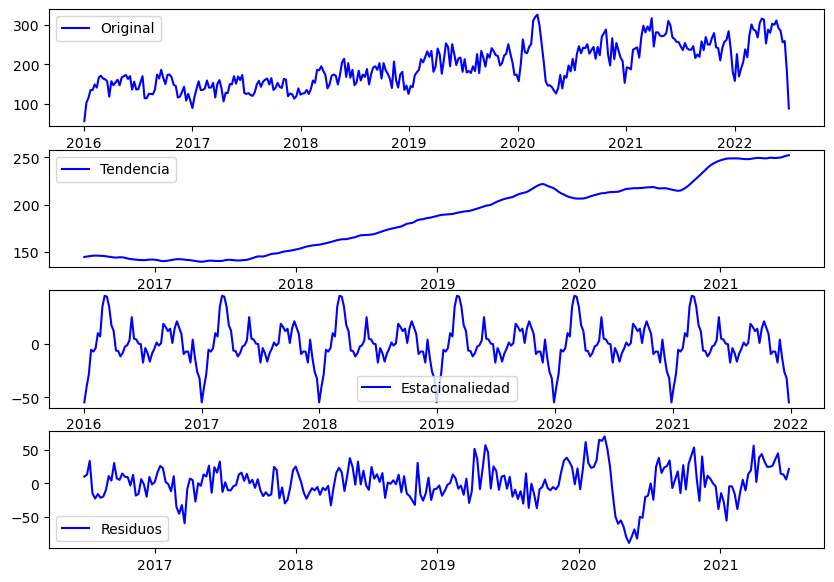

In [128]:
amenazas = pd.read_csv("../Data/amenazas.csv", parse_dates=["fecha_hechos"])
amenazas.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
amenazas.index = pd.DatetimeIndex(amenazas.fecha_hechos)

amenazas_x_sem = amenazas.resample("W", on = "fecha_hechos").size()
ts_train_amenazas=amenazas_x_sem[amenazas_x_sem.index<'2022']
ts_test_amenazas=amenazas_x_sem[amenazas_x_sem.index>='2022']

descomposicion(ts_train_amenazas, amenazas_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2873.957, Time=5.36 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3353.281, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2890.399, Time=1.85 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3114.447, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4191.256, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=2873.646, Time=2.80 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=2878.957, Time=0.25 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=2874.392, Time=12.44 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=2872.853, Time=4.55 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=2874.119, Time=20.08 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=2876.256, Time=14.03 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=2870.866, Time=2.91 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=2876.972, Time=0.21 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=2872.119, Time=14.99 sec
 ARIMA(1,0,2)(1

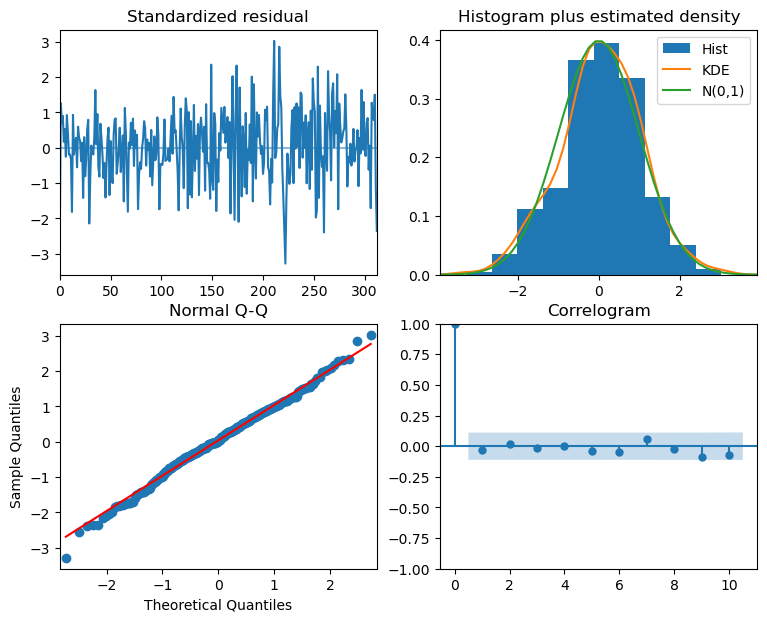

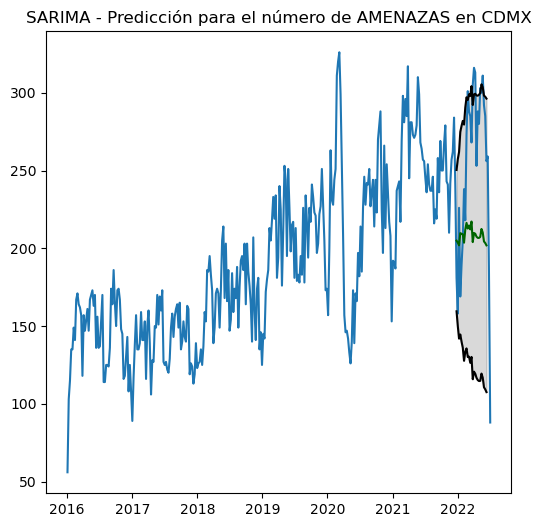

MAPE: 0.229993


In [129]:
model_plot(df_train = ts_train_amenazas, n_periodos = 25, df_ori = amenazas_x_sem, 
           categoria = "AMENAZAS", df_test = ts_test_amenazas)

## ROBO A NEGOCIO SIN VIOLENCIA

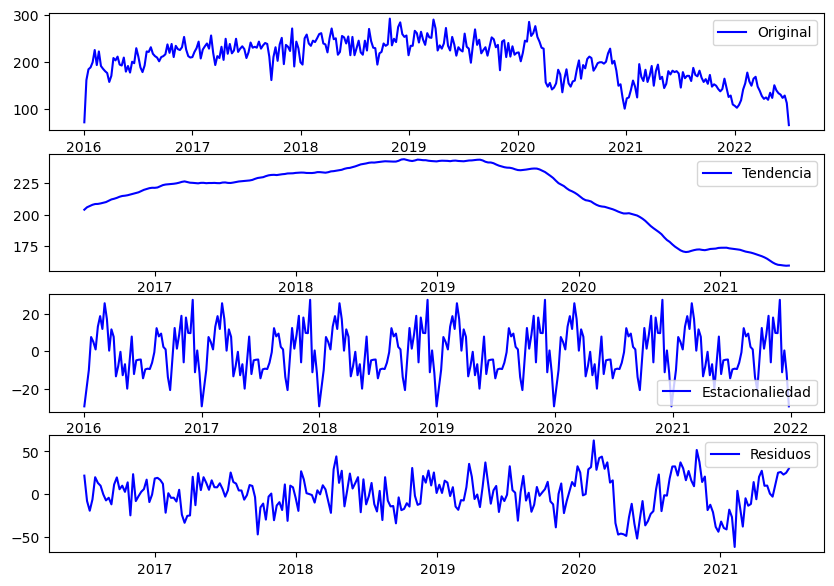

In [131]:
robo_neg_sin = pd.read_csv("../Data/robo_neg_sin.csv", parse_dates=["fecha_hechos"])
robo_neg_sin.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_neg_sin.index = pd.DatetimeIndex(robo_neg_sin.fecha_hechos)

robo_neg_sin_x_sem = robo_neg_sin.resample("W", on = "fecha_hechos").size()
ts_train_robo_neg_sin=robo_neg_sin_x_sem[robo_neg_sin_x_sem.index<'2022']
ts_test_robo_neg_sin=robo_neg_sin_x_sem[robo_neg_sin_x_sem.index>='2022']

descomposicion(ts_train_robo_neg_sin, robo_neg_sin_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.66 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2862.817, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2817.792, Time=1.04 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2800.955, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2860.825, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2804.436, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2800.412, Time=4.02 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=11.97 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=2861.553, Time=4.55 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=2800.411, Time=5.33 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=2801.244, Time=1.16 sec
 ARIMA(1,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=14.59 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC

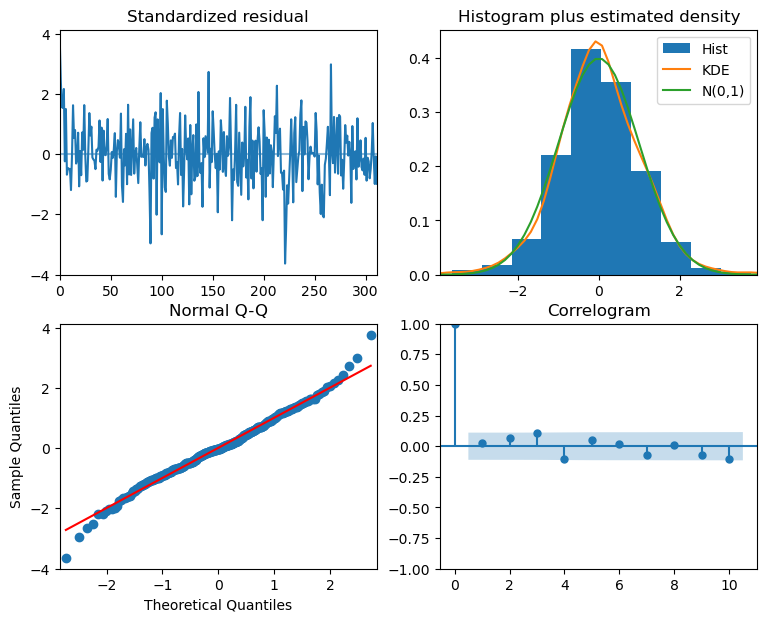

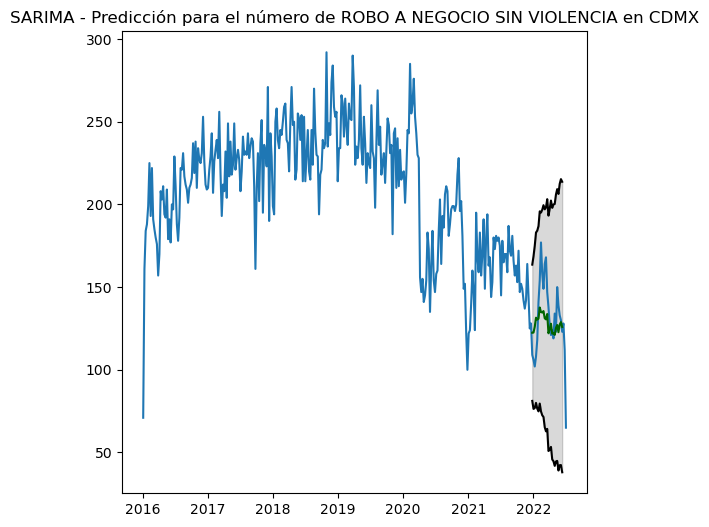

MAPE: 0.100057


In [132]:
model_plot(df_train = ts_train_robo_neg_sin, n_periodos = 25, df_ori = robo_neg_sin_x_sem, 
           categoria = "ROBO A NEGOCIO SIN VIOLENCIA", df_test = ts_test_robo_neg_sin)

## FRAUDE

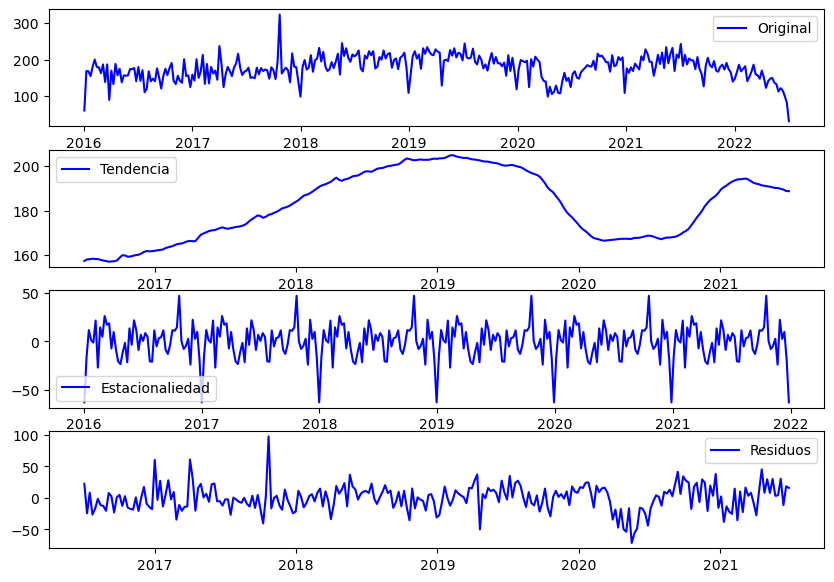

In [133]:
fraude = pd.read_csv("../Data/fraude.csv", parse_dates=["fecha_hechos"])
fraude.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
fraude.index = pd.DatetimeIndex(fraude.fecha_hechos)

fraude_x_sem = fraude.resample("W", on = "fecha_hechos").size()
ts_train_fraude=fraude_x_sem[fraude_x_sem.index<'2022']
ts_test_fraude=fraude_x_sem[fraude_x_sem.index>='2022']

descomposicion(ts_train_fraude, fraude_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3091.577, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2965.480, Time=0.98 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2928.466, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3089.595, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2953.604, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=2901.570, Time=1.31 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2916.438, Time=0.83 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=2900.851, Time=5.35 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2900.627, Time=3.98 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=2901.906, Time=5.43 sec
 ARIMA(0,1,2)(2,0,0)[52] intercept   : AIC=2901.946, Time=4.50 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=3.25 sec
 ARIMA(1,1,2)(2,0,0)[52] intercept

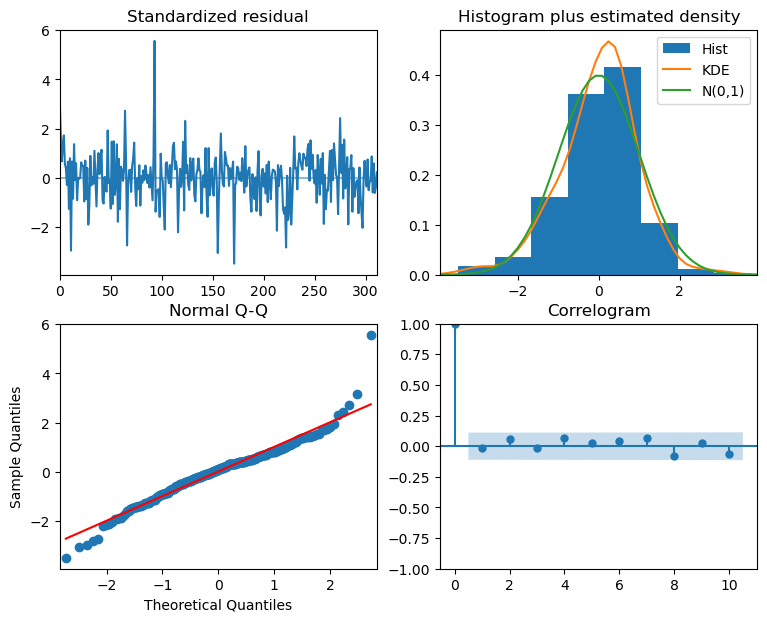

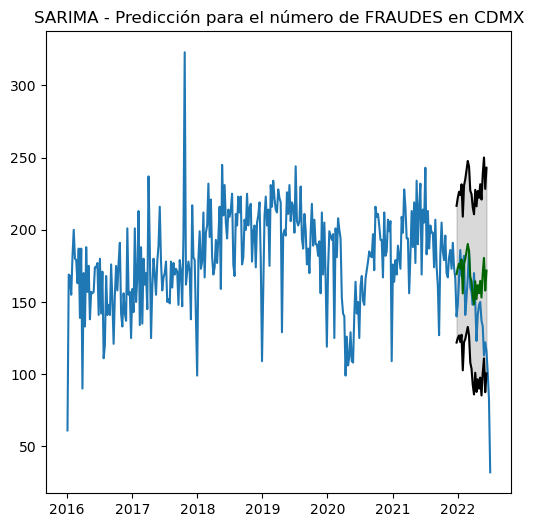

MAPE: 0.175150


In [134]:
model_plot(df_train = ts_train_fraude, n_periodos = 25, df_ori = fraude_x_sem, 
           categoria = "FRAUDES", df_test = ts_test_fraude)

## ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA

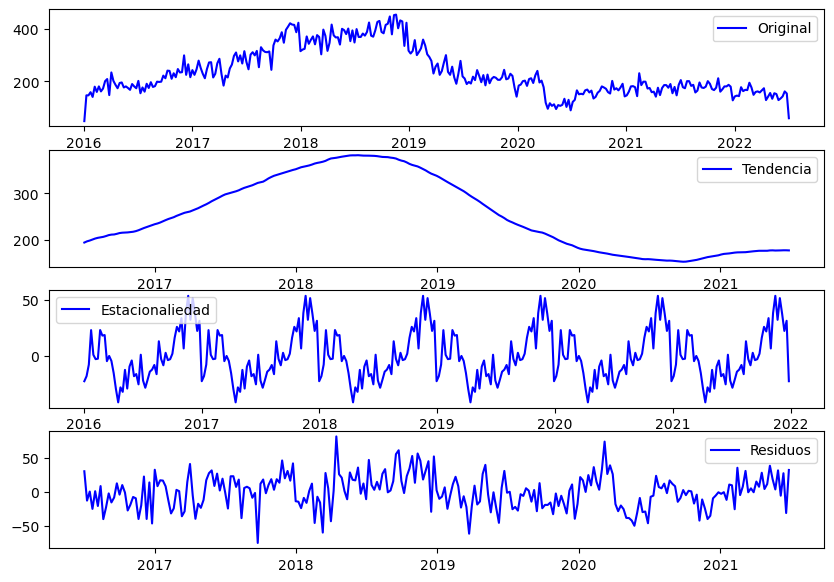

In [135]:
robo_transeuntes = pd.read_csv("../Data/robo_transeuntes.csv", parse_dates=["fecha_hechos"])
robo_transeuntes.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_transeuntes.index = pd.DatetimeIndex(robo_transeuntes.fecha_hechos)

robo_transeuntes_x_sem = robo_transeuntes.resample("W", on = "fecha_hechos").size()
ts_train_robo_transeuntes=robo_transeuntes_x_sem[robo_transeuntes_x_sem.index<'2022']
ts_test_robo_transeuntes=robo_transeuntes_x_sem[robo_transeuntes_x_sem.index>='2022']

descomposicion(ts_train_robo_transeuntes, robo_transeuntes_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3058.821, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3003.263, Time=1.00 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2975.764, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3056.840, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2978.117, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=2977.571, Time=4.06 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2975.525, Time=0.87 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=2977.195, Time=4.46 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=13.90 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=3057.677, Time=0.53 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2977.493, Time=1.11 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2977.486, Time=1.18 sec
 ARIMA(1,1,2)(1,0,0)[52] intercep

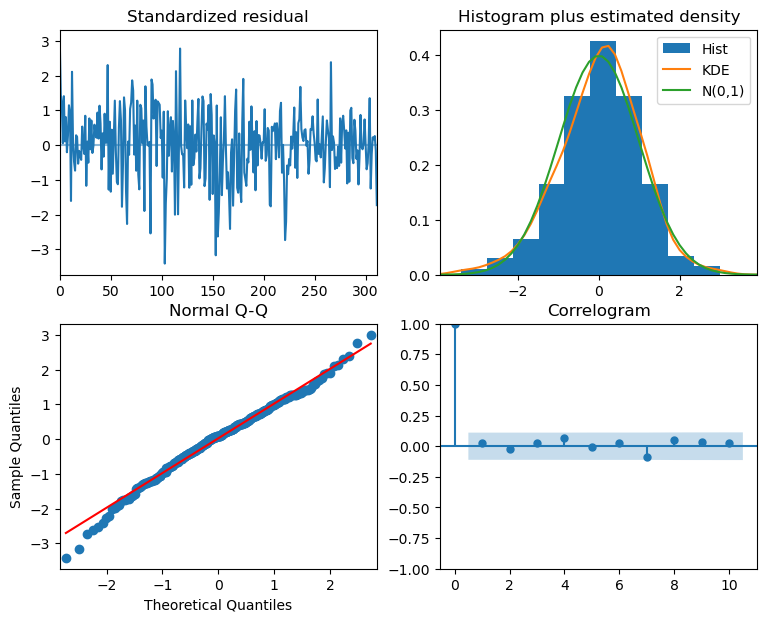

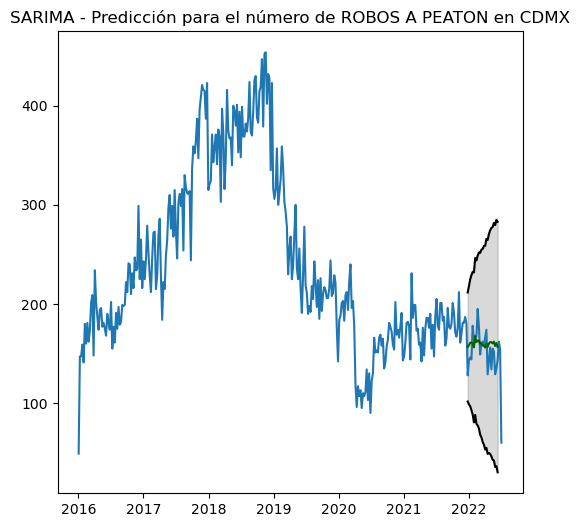

MAPE: 0.089589


In [136]:
model_plot(df_train = ts_train_robo_transeuntes, n_periodos = 25, df_ori = robo_transeuntes_x_sem, 
           categoria = "ROBOS A PEATON", df_test = ts_test_robo_transeuntes)

## VIOLENCIA FAMILIAR

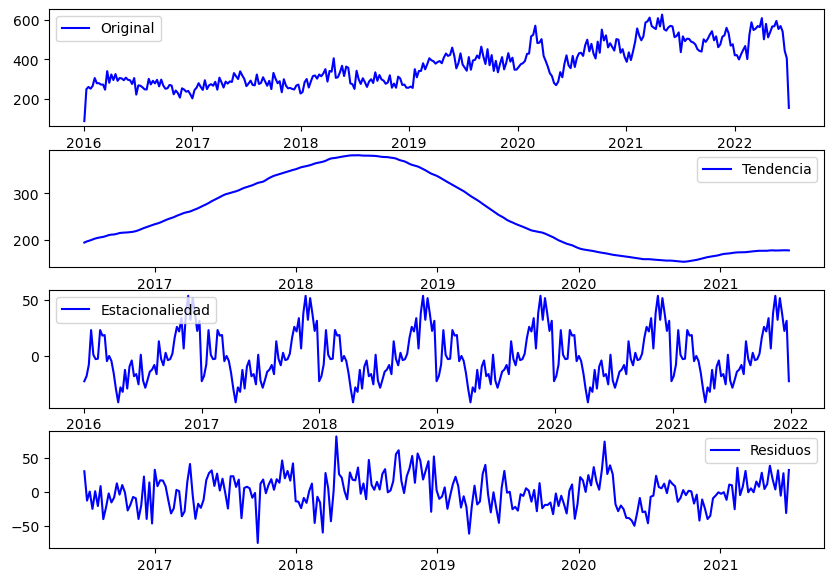

In [137]:
violencia_familiar = pd.read_csv("../Data/violencia_familiar.csv", parse_dates=["fecha_hechos"])
violencia_familiar.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
violencia_familiar.index = pd.DatetimeIndex(violencia_familiar.fecha_hechos)

violencia_familiar_x_sem = violencia_familiar.resample("W", on = "fecha_hechos").size()
ts_train_violencia_familiar=violencia_familiar_x_sem[violencia_familiar_x_sem.index<'2022']
ts_test_violencia_familiar=violencia_familiar_x_sem[violencia_familiar_x_sem.index>='2022']

descomposicion(ts_train_robo_transeuntes, violencia_familiar_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3773.361, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3182.398, Time=1.23 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3513.141, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=4600.452, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=3181.714, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=3182.398, Time=1.30 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=3184.397, Time=2.63 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=3128.686, Time=0.12 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=3130.524, Time=1.69 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=3130.546, Time=1.75 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=3128.019, Time=0.19 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=3130.012, Time=2.39 sec
 ARIMA(3,0,0)(0,0,1)[52] inte

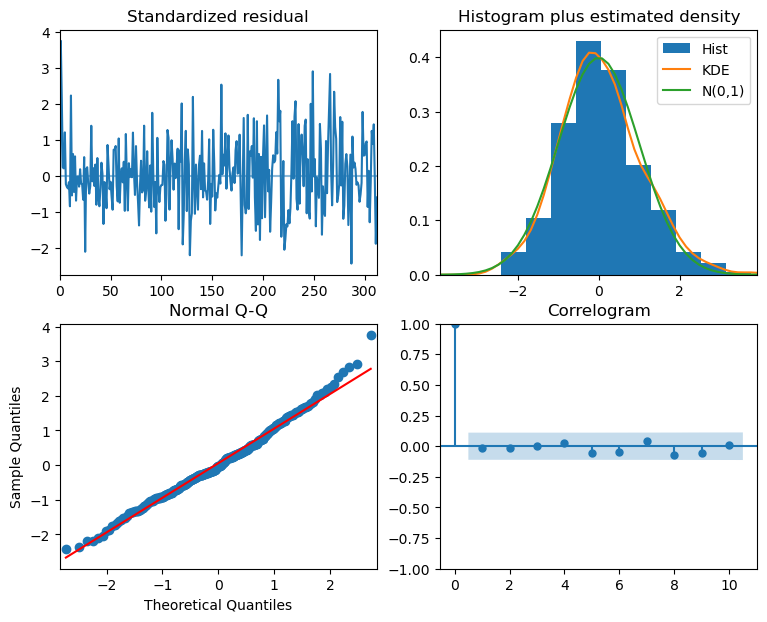

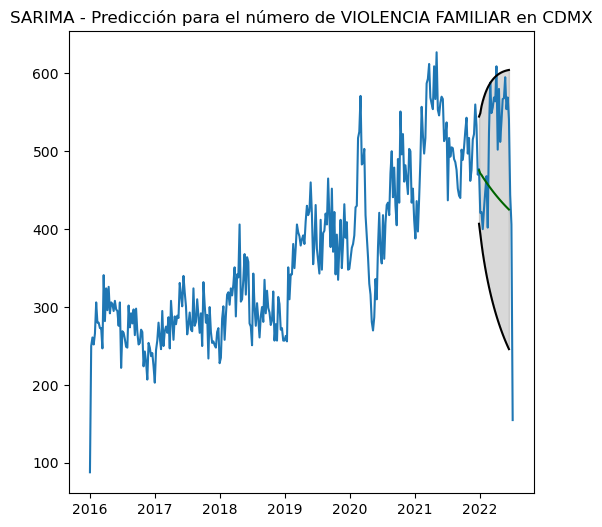

MAPE: 0.170846


In [138]:
model_plot(df_train = ts_train_violencia_familiar, n_periodos = 25, df_ori = violencia_familiar_x_sem, 
           categoria = "VIOLENCIA FAMILIAR", df_test = ts_test_violencia_familiar)

## ROBO DE OBJETOS

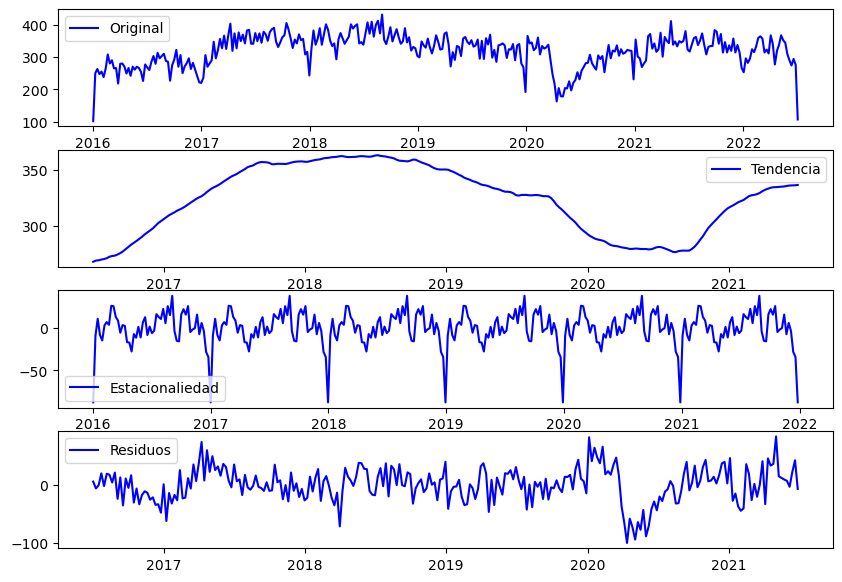

In [139]:
robo_objetos = pd.read_csv("../Data/robo_objetos.csv", parse_dates=["fecha_hechos"])
robo_objetos.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
robo_objetos.index = pd.DatetimeIndex(robo_objetos.fecha_hechos)

robo_objetos_x_sem = robo_objetos.resample("W", on = "fecha_hechos").size()
ts_train_robo_objetos=robo_objetos_x_sem[robo_objetos_x_sem.index<'2022']
ts_test_robo_objetos=robo_objetos_x_sem[robo_objetos_x_sem.index>='2022']

descomposicion(ts_train_robo_objetos, robo_objetos_x_sem)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.37 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3122.441, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3047.708, Time=0.97 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3033.693, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3120.508, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3042.982, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=3025.027, Time=4.21 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=inf, Time=13.21 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=3116.253, Time=4.06 sec
 ARIMA(1,1,1)(0,0,2)[52] intercept   : AIC=3026.989, Time=6.61 sec
 ARIMA(0,1,2)(0,0,2)[52] intercept   : AIC=3027.000, Time=5.74 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=3043.967, Time=4.61 sec
 ARIMA(1,1,2)(0,0,2)[52] intercept   : AIC=3027.635, Time=10.90 sec
 ARIMA(0,1,1)(0,0,2)[52]        

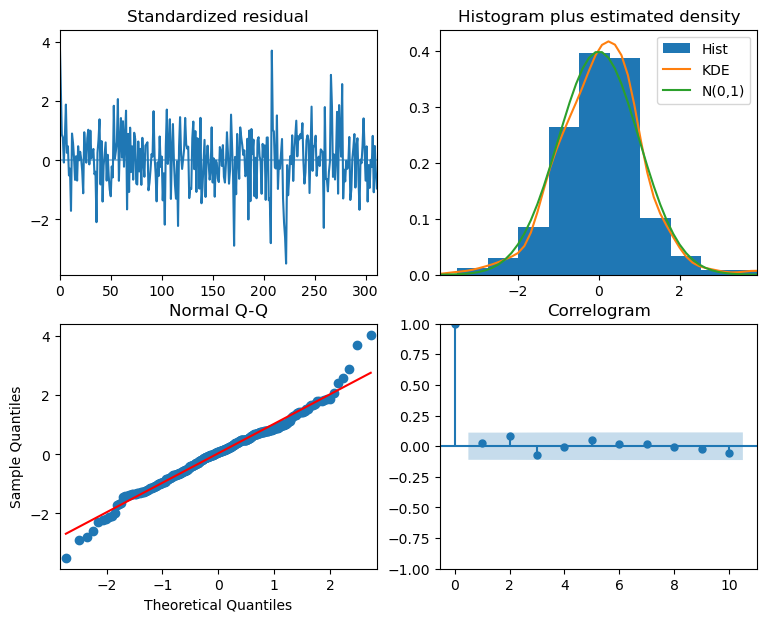

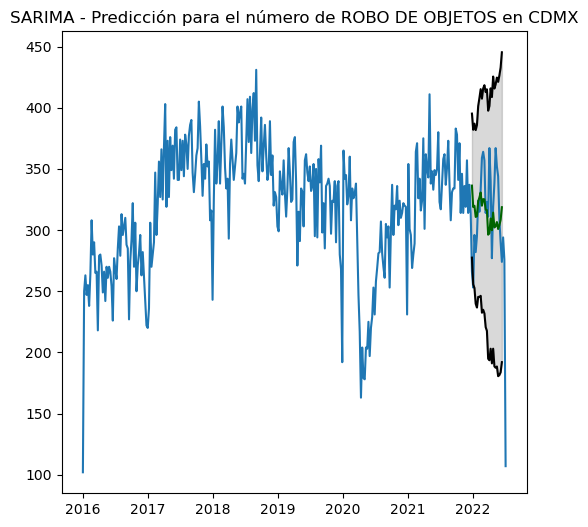

MAPE: 0.092501


In [140]:
model_plot(df_train = ts_train_robo_objetos, n_periodos = 25, df_ori = robo_objetos_x_sem, 
           categoria = "ROBO DE OBJETOS", df_test = ts_test_robo_objetos)